In [1]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from coin_if import COINWrapper,read_COIN_params

In [3]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [4]:
from multiprocessing import Pool

# Create a helper function that unpacks a tuple of arguments
def parallel_wrapped_runner_item(args):
    k, stimuli_data, opt_data_k = args
    return k, wrapped_runner(stimuli_data, opt_data_k)

def parallel_wrapped_runner(args_list, return_dict=False):
    with Pool() as pool:
        results = pool.map(parallel_wrapped_runner_item,args_list)
    if return_dict:
        return dict(results)
    else: # list of result items
        return [results[1]  for results in results]



In [5]:
from coin_if import read_COIN_params
raw_coin_params = read_COIN_params('/fitted_parameters/')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked_recovery', 'spontaneous_recovery','memory_updating']

paradigm_short = {
    'evoked_recovery': 'E',
    'spontaneous_recovery': 'S',
    'memory_updating': 'M',
}

paradigm_info = {
    'evoked_recovery': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous_recovery': {
        'i_min': 1,
        'i_max': 8,},
    'memory_updating': {
        'i_min': 1,
        'i_max': 24,},
    
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
param_names = [k for k in raw_coin_params['E1'].keys()]

# 
param_remapping = {'prior_sigma_retention': {'name':'prior_precision_retention', 'fun': lambda x: 1/x**2},
                   'prior_sigma_drift': {'name':'prior_precision_drift', 'fun': lambda x: 1/x**2}}

def remap_params(params):
    for k in param_remapping.keys():
        if k in params:
            new_name = param_remapping[k]['name']
            new_value = param_remapping[k]['fun'](params[k])
            params[new_name] = new_value
            del params[k]
    return params
                   

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            # with open(f'{ROOT_PATH}/experimental/coin_{paradigm}_run012_MSE_{i}.pkl','rb') as f:
            #     opt_data[id] = pickle.load(f)
            kk = paradigm_short[paradigm]+str(i)
            #opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            opt_data[id] = {'MSE':{'x':[]}}
            for p in param_names:
                _val = raw_coin_params[kk][p]
                if p in param_remapping.keys():
                    _val = param_remapping[p]['fun'](_val)
                opt_data[id]['MSE']['x'].append(_val)
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

#remapping param_names
new_param_names = []
for k in param_names:
    if k in param_remapping.keys():
        new_param_names.append(param_remapping[k]['name'])
    else:
        new_param_names.append(k)
param_names = new_param_names

In [8]:
param_names

['sigma_process_noise',
 'prior_mean_retention',
 'prior_precision_retention',
 'prior_precision_drift',
 'alpha_context',
 'rho_context',
 'sigma_motor_noise',
 'alpha_cue']

In [9]:
paradigm_by_id_lut

{0: 'evoked_recovery',
 1: 'evoked_recovery',
 2: 'evoked_recovery',
 3: 'evoked_recovery',
 4: 'evoked_recovery',
 5: 'evoked_recovery',
 6: 'evoked_recovery',
 7: 'evoked_recovery',
 8: 'spontaneous_recovery',
 9: 'spontaneous_recovery',
 10: 'spontaneous_recovery',
 11: 'spontaneous_recovery',
 12: 'spontaneous_recovery',
 13: 'spontaneous_recovery',
 14: 'spontaneous_recovery',
 15: 'spontaneous_recovery',
 16: 'memory_updating',
 17: 'memory_updating',
 18: 'memory_updating',
 19: 'memory_updating',
 20: 'memory_updating',
 21: 'memory_updating',
 22: 'memory_updating',
 23: 'memory_updating',
 24: 'memory_updating',
 25: 'memory_updating',
 26: 'memory_updating',
 27: 'memory_updating',
 28: 'memory_updating',
 29: 'memory_updating',
 30: 'memory_updating',
 31: 'memory_updating',
 32: 'memory_updating',
 33: 'memory_updating',
 34: 'memory_updating',
 35: 'memory_updating',
 36: 'memory_updating',
 37: 'memory_updating',
 38: 'memory_updating',
 39: 'memory_updating'}

In [10]:
opt_data

{0: {'MSE': {'x': [0.1234,
    0.8827,
    3086.4197530864203,
    17313.019390581718,
    120.0,
    0.2699,
    0.0901,
    nan]}},
 1: {'MSE': {'x': [0.1441,
    0.9121,
    11111111.111111114,
    13211.784912141633,
    380.0,
    0.1285,
    0.0804,
    nan]}},
 2: {'MSE': {'x': [0.1119,
    0.9466,
    277777777.77777773,
    17777.777777777777,
    230.0,
    0.007,
    0.0781,
    nan]}},
 3: {'MSE': {'x': [0.1172,
    0.8578,
    6944.444444444444,
    28727.37719046251,
    12.0,
    0.0477,
    0.0883,
    nan]}},
 4: {'MSE': {'x': [0.0705,
    0.946,
    591715.976331361,
    38446.75124951941,
    10000000.0,
    0.3911,
    0.0715,
    nan]}},
 5: {'MSE': {'x': [0.0559,
    0.9643,
    111111.11111111111,
    41649.312786339025,
    29.0,
    0.0044,
    0.0966,
    nan]}},
 6: {'MSE': {'x': [0.0926,
    0.9422,
    3906250000.0,
    91827.36455463729,
    3700000.0,
    0.0003,
    0.0936,
    nan]}},
 7: {'MSE': {'x': [0.099,
    0.8405,
    189035.91682419658,
    198

In [11]:
def scale_and_bias(x,bias=0,scale=1.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(runs=10)        

fixed_params['runner'] = {
    "runner_method_alias": "blackbox",  
    "model_type": "coin",               # Distinguish from 'torch' or 'numpy'
    "do_backprop": False,               # No training/backpropagation for COIN
    "load_model_at_init": False,        # COIN doesn’t support state_dict saving/loading
    "save_model_at_init": False,        # Ensure no torch parameter saving is attempted
    'initial_state': [], 
    "tau_u": 1,                        # Can be set if needed (may be unused in COIN mode)
}



optim_param_mapping= [('model', param_name) for param_name in param_names] 
            
custom_param_mappings = []

wrapped_runner = wrap_runner_for_optimization(model_class = COINWrapper,
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [12]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous_recovery': [(P0, 50),
                        (Pplus, 120),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked_recovery': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)],
                        'memory_updating': [(P0, 50)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [13]:
pooling_fun = 'MSE'

In [14]:
banabreak

NameError: name 'banabreak' is not defined

In [ ]:
# args_list = [(k,stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data]

# with Pool() as pool:
#     results = pool.map(parallel_runner,args_list)

# outs = dict(results)

outs = parallel_wrapped_runner([(k,stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data],return_dict=True)

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encounter

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
 10%|█         | 1/10 [00:01<00:13,  1.51s/it

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model

Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weight

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 30%|███       | 3/10 [00:03<00:09,  1.33s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
 30%|███       | 3/10 [00:05<00:12,  1.76s/it]/homes/ar23

Simulting the COIN model


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Simulting the COIN model


 80%|████████  | 8/10 [00:14<00:03,  1.82s/it]

Simulting the COIN model


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)



Simulting the COIN model


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Simulting the COIN model

 20%|██        | 2/10 [00:03<00:13,  1.74s/it]

100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


Simulting the COIN model


 10%|█         | 1/10 [00:19<02:53, 19.28s/it]

Simulting the COIN model


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Simulting the COIN model


 40%|████      | 4/10 [00:57<01:21, 13.65s/it]Process ForkPoolWorker-30:
Process ForkPoolWorker-31:
Process ForkPoolWorker-29:
Process ForkPoolWorker-32:
Process ForkPoolWorker-23:
Process ForkPoolWorker-25:
 30%|███       | 3/10 [00:56<02:12, 18.99s/it]Process ForkPoolWorker-18:
Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
 40%|████      | 4/10 [00:57<01:25, 14.33s/it]Process ForkPoolWorker-24:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
 30%|███       | 3/10 [00:57<02:14, 19.19s/it]Process ForkPoolWorker-19:
















Process ForkPoolWorker-15:
Process ForkPoolWorker-11:
Process ForkPoolWorker-13:
Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Process ForkPoolWorker-14:
Process ForkPoolWorker-1:
Process ForkPoolWorker-8:
Process ForkPoolWorker-3:
Process ForkPoolWorker-12:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-16:
Traceback (most recent cal

In [ ]:
# outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}

Text(0.5, 1.0, 'subjects -->>1')

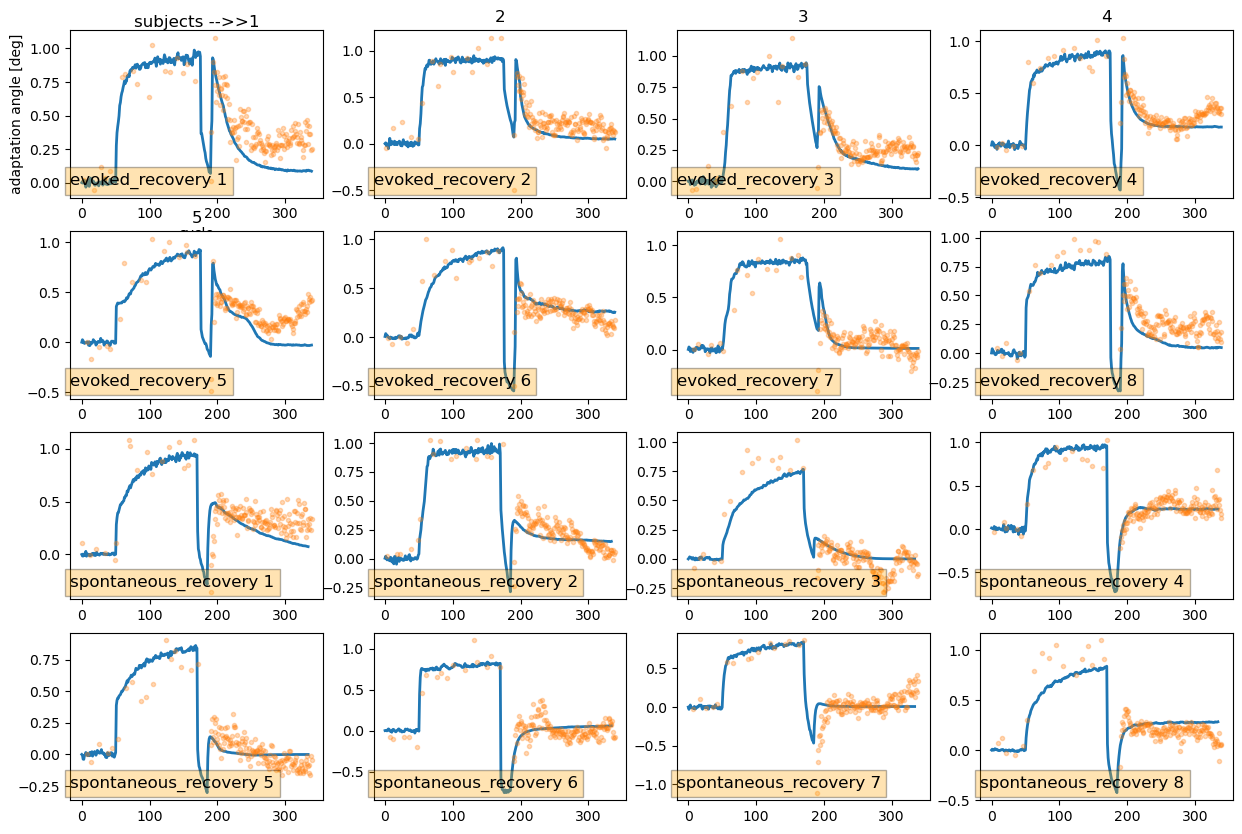

In [ ]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [ ]:
outs_ = [o for _,o in outs.items()]
outs_ = np.array(outs_)
data_ = np.array([data[k] for k in opt_data])

/tmp/ipykernel_4154010/546502521.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  outs_ = np.array(outs_)


In [ ]:
nana_break

NameError: name 'nana_break' is not defined

In [ ]:
opt_data

{0: {'MSE': {'x': [0.1234,
    0.8827,
    3086.4197530864203,
    17313.019390581718,
    120.0,
    0.2699,
    0.0901,
    nan]}},
 1: {'MSE': {'x': [0.1441,
    0.9121,
    11111111.111111114,
    13211.784912141633,
    380.0,
    0.1285,
    0.0804,
    nan]}},
 2: {'MSE': {'x': [0.1119,
    0.9466,
    277777777.77777773,
    17777.777777777777,
    230.0,
    0.007,
    0.0781,
    nan]}},
 3: {'MSE': {'x': [0.1172,
    0.8578,
    6944.444444444444,
    28727.37719046251,
    12.0,
    0.0477,
    0.0883,
    nan]}},
 4: {'MSE': {'x': [0.0705,
    0.946,
    591715.976331361,
    38446.75124951941,
    10000000.0,
    0.3911,
    0.0715,
    nan]}},
 5: {'MSE': {'x': [0.0559,
    0.9643,
    111111.11111111111,
    41649.312786339025,
    29.0,
    0.0044,
    0.0966,
    nan]}},
 6: {'MSE': {'x': [0.0926,
    0.9422,
    3906250000.0,
    91827.36455463729,
    3700000.0,
    0.0003,
    0.0936,
    nan]}},
 7: {'MSE': {'x': [0.099,
    0.8405,
    189035.91682419658,
    198

In [15]:
A_times = [0,5,10,20] 
# antero_short   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}
antero_short = {aa: parallel_wrapped_runner([(k,[(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data]) for aa,A_time in enumerate(A_times)}

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 10%|█         | 1/10 [00:00<00:08,  1.08it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
 10%|█         | 1/10 [00:00<00:08,  1.05it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
 10%|█         | 1/10 [00:01<00:09,  1.01s/it]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 10%|█         | 1/10 [00:01<00:09,  1.00s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 20%|██        | 2/10 [00:01<00:07,  1.01it/s]

Simulting the COIN model


 10%|█         | 1/10 [00:01<00:10,  1.12s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

 10%|█         | 1/10 [00:00<00:08,  1.02it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


 10%|█         | 1/10 [00:01<00:09,  1.08s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 10%|█         | 1/10 [00:00<00:08,  1.03it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
 10%|█         | 1/10 [00:01<00:09,  1.05s/it]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Simulting the COIN model


 90%|█████████ | 9/10 [00:09<00:01,  1.06s/it]]


Simulting the COIN model


 90%|█████████ | 9/10 [00:09<00:01,  1.09s/it]]


Simulting the COIN model


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]

Simulting the COIN model


Simulting the COIN model


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Simulting the COIN model

 90%|█████████ | 9/10 [00:09<00:01,  1.06s/it]

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

Simulting the COIN model

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model




/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 10%|█         | 1/10 [00:01<00:13,  1.51s/it]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
 10%|█         | 1/10 [00:01<00:13,  1.45s/it]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

 10%|█         | 1/10 [00:01<00:14,  1.56s/it]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 10%|█         | 1/10 [00:01<00:13,  1.55s/it]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 20%|██        | 2/10 [00:03<00:13,  1.68s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

Simulting the COIN model

100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


Simulting the COIN model

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

Simulting the COIN model

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


 10%|█         | 1/10 [00:01<00:15,  1.71s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
 10%|█         | 1/10 [00:01<00:14,  1.65s/it]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 10%|█         | 1/10 [00:01<00:16,  1.80s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) 

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

 10%|█         | 1/10 [00:01<00:15,  1.70s/it]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


Simulting the COIN model


 90%|█████████ | 9/10 [00:18<00:02,  2.14s/it]

Simulting the COIN model


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


Simulting the COIN model


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600:

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



 10%|█         | 1/10 [00:01<00:16,  1.88s/it]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600:

Simulting the COIN model


 90%|█████████ | 9/10 [00:20<00:02,  2.29s/it]

Simulting the COIN model


 90%|█████████ | 9/10 [00:20<00:02,  2.25s/it]

Simulting the COIN model


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Simulting the COIN model

100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

 90%|█████████ | 9/10 [00:21<00:02,  2.34s/it]]


Simulting the COIN model


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


100%|██████████| 10/10 [00:22<00:00,  2.30s/it]

Simulting the COIN model

100%|██████████| 10/10 [00:23<00:00,  2.31s/it]

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


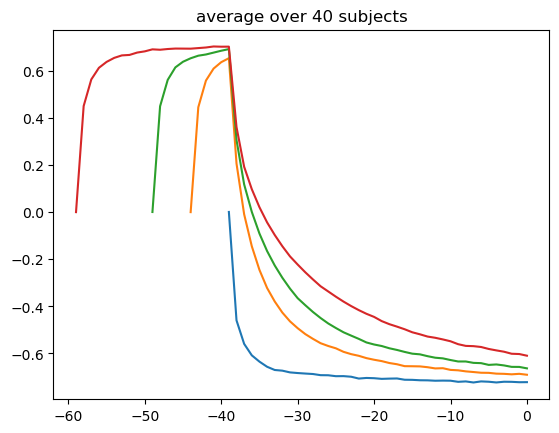

In [16]:
for aa,A_time in enumerate(A_times):
    y = np.nanmean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    plt.title(f'average over {len(antero_short[aa])} subjects')
    

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)




Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: 

Simulting the COIN model


100%|██████████| 10/10 [01:37<00:00,  9.72s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:40<00:00, 10.04s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:45<00:00, 10.57s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:47<00:00, 10.70s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:47<00:00, 10.77s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:55<00:00, 11.54s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:57<00:00, 11.78s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:06<00:00,  6.69s/it]


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600:

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  co

Simulting the COIN model


100%|██████████| 10/10 [01:54<00:00, 11.45s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:55<00:00, 11.52s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:06<00:00, 12.63s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:08<00:00, 12.86s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:08<00:00, 12.87s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:09<00:00, 12.94s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:10<00:00, 13.06s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:33<00:00, 15.39s/it]

100%|██████████| 10/10 [01:25<00:00,  8.58s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
 20%|██        | 2/10 [00:30<02:03, 15.41s/it

Simulting the COIN model


100%|██████████| 10/10 [02:10<00:00, 13.10s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:19<00:00, 13.97s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:23<00:00, 14.31s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:23<00:00, 14.36s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:23<00:00, 14.40s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:25<00:00, 14.52s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:28<00:00, 14.87s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:24<00:00,  8.44s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


Simulting the COIN modelSimulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
 10%|█         | 1/10 [00:20<03:03, 20.35s/it

Simulting the COIN model


 90%|█████████ | 9/10 [02:48<00:18, 18.58s/it]]


Simulting the COIN model


100%|██████████| 10/10 [02:57<00:00, 17.76s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:01<00:00, 18.18s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:06<00:00, 18.65s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:07<00:00, 18.75s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:09<00:00, 18.91s/it]


Simulting the COIN model


100%|██████████| 10/10 [03:09<00:00, 19.00s/it]


Simulting the COIN model


100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model
Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
 10%|█         | 1/10 [00:30<04:30, 30.06s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 10/10 [04:00<00:00, 24.02s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:01<00:00, 24.12s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:12<00:00, 25.22s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:19<00:00, 25.91s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:24<00:00, 26.40s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:22<00:00, 26.28s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:25<00:00, 26.56s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:24<00:00, 26.43s/it]


Simulting the COIN model


100%|██████████| 10/10 [02:26<00:00, 14.62s/it]


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN model



  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/genera

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN modelSimulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|          | 0/10 [00:00<?, ?it/s]

Simulting the COIN modelSimulting the COIN modelSimulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600:

Simulting the COIN model


  0%|          | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
 10%|█         | 1/10 [00:45<06:49, 45.50s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
100%|██████████| 10/10 [06:10<00:00, 37.06s/it]


Simulting the COIN model


100%|██████████| 10/10 [06:18<00:00, 37.84s/it]


Simulting the COIN model


100%|██████████| 10/10 [06:25<00:00, 38.54s/it]


Simulting the COIN model


100%|██████████| 10/10 [06:27<00:00, 38.77s/it]


Simulting the COIN model


100%|██████████| 10/10 [06:34<00:00, 39.42s/it]


Simulting the COIN model


100%|██████████| 10/10 [06:38<00:00, 39.90s/it]


Simulting the COIN model


100%|██████████| 10/10 [06:40<00:00, 40.08s/it]


Simulting the COIN model


100%|██████████| 10/10 [06:47<00:00, 40.78s/it]


Simulting the COIN model


100%|██████████| 10/10 [04:13<00:00, 25.34s/it]


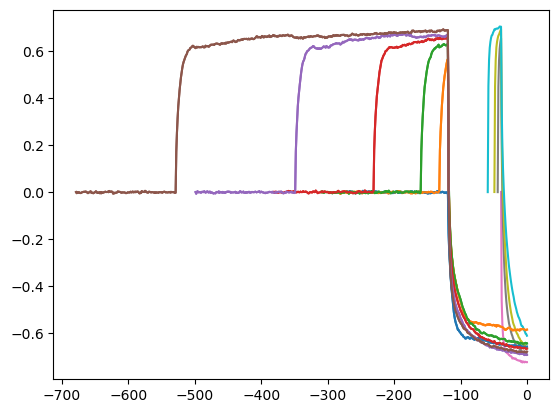

In [17]:
TaN=150
TaB=120

ref_antero_playlist = {'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)]}

# antero   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in ref_antero_playlist.items()}
antero = {aa: parallel_wrapped_runner([(k,aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data]) for aa,aa_item in ref_antero_playlist.items()}
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
# frog_ens = [True,False]
# Tfrog = 400
# frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}
# for frog_en in frog_ens:
#     plt.plot(np.mean(frogs[frog_en],axis=0))
# from siggen_utils import herzfeld_block


# def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
#     out_dict = {}
#     for z in z_list:
#         scenario_name =  f'herzfeld,z={z}'
#         pert_per_z = []
#         for n in range(n_blocks):
#             hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
#             pert_per_z.append((hz,len(hz)))
#         out_dict.update({scenario_name:pert_per_z})
#     return out_dict

# hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
# hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
# # her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}
# her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}
# for iz, z in enumerate(hrz_params['z_list']):
#     deltas = []
#     mm = lambda x: np.mean(x,axis=0)
#     scenario = f'herzfeld,z={z}'
#     this_result = her_results[scenario]
#     pointer = 0
#     for bb in range(hrz_params['n_blocks']):
#         block_length = hrz_playlist[scenario][bb][-1]
#         pointer += block_length
#         deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

#     plt.plot(deltas,'x',label = f'z={z}')


# # for frog_en in frog_ens:
# #     plt.plot(np.mean(frogs[frog_en],axis=0))

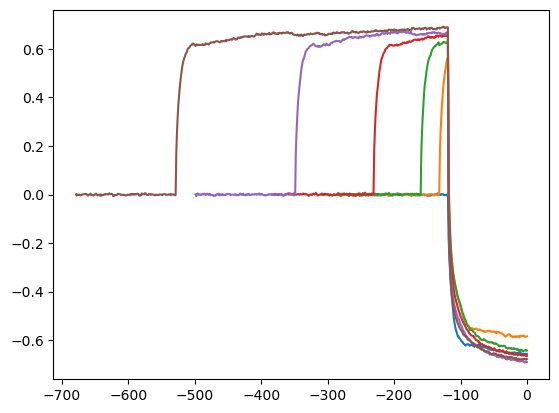

In [18]:
for aa,aa_item in antero.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

In [ ]:
antero.keys()

NameError: name 'antero' is not defined

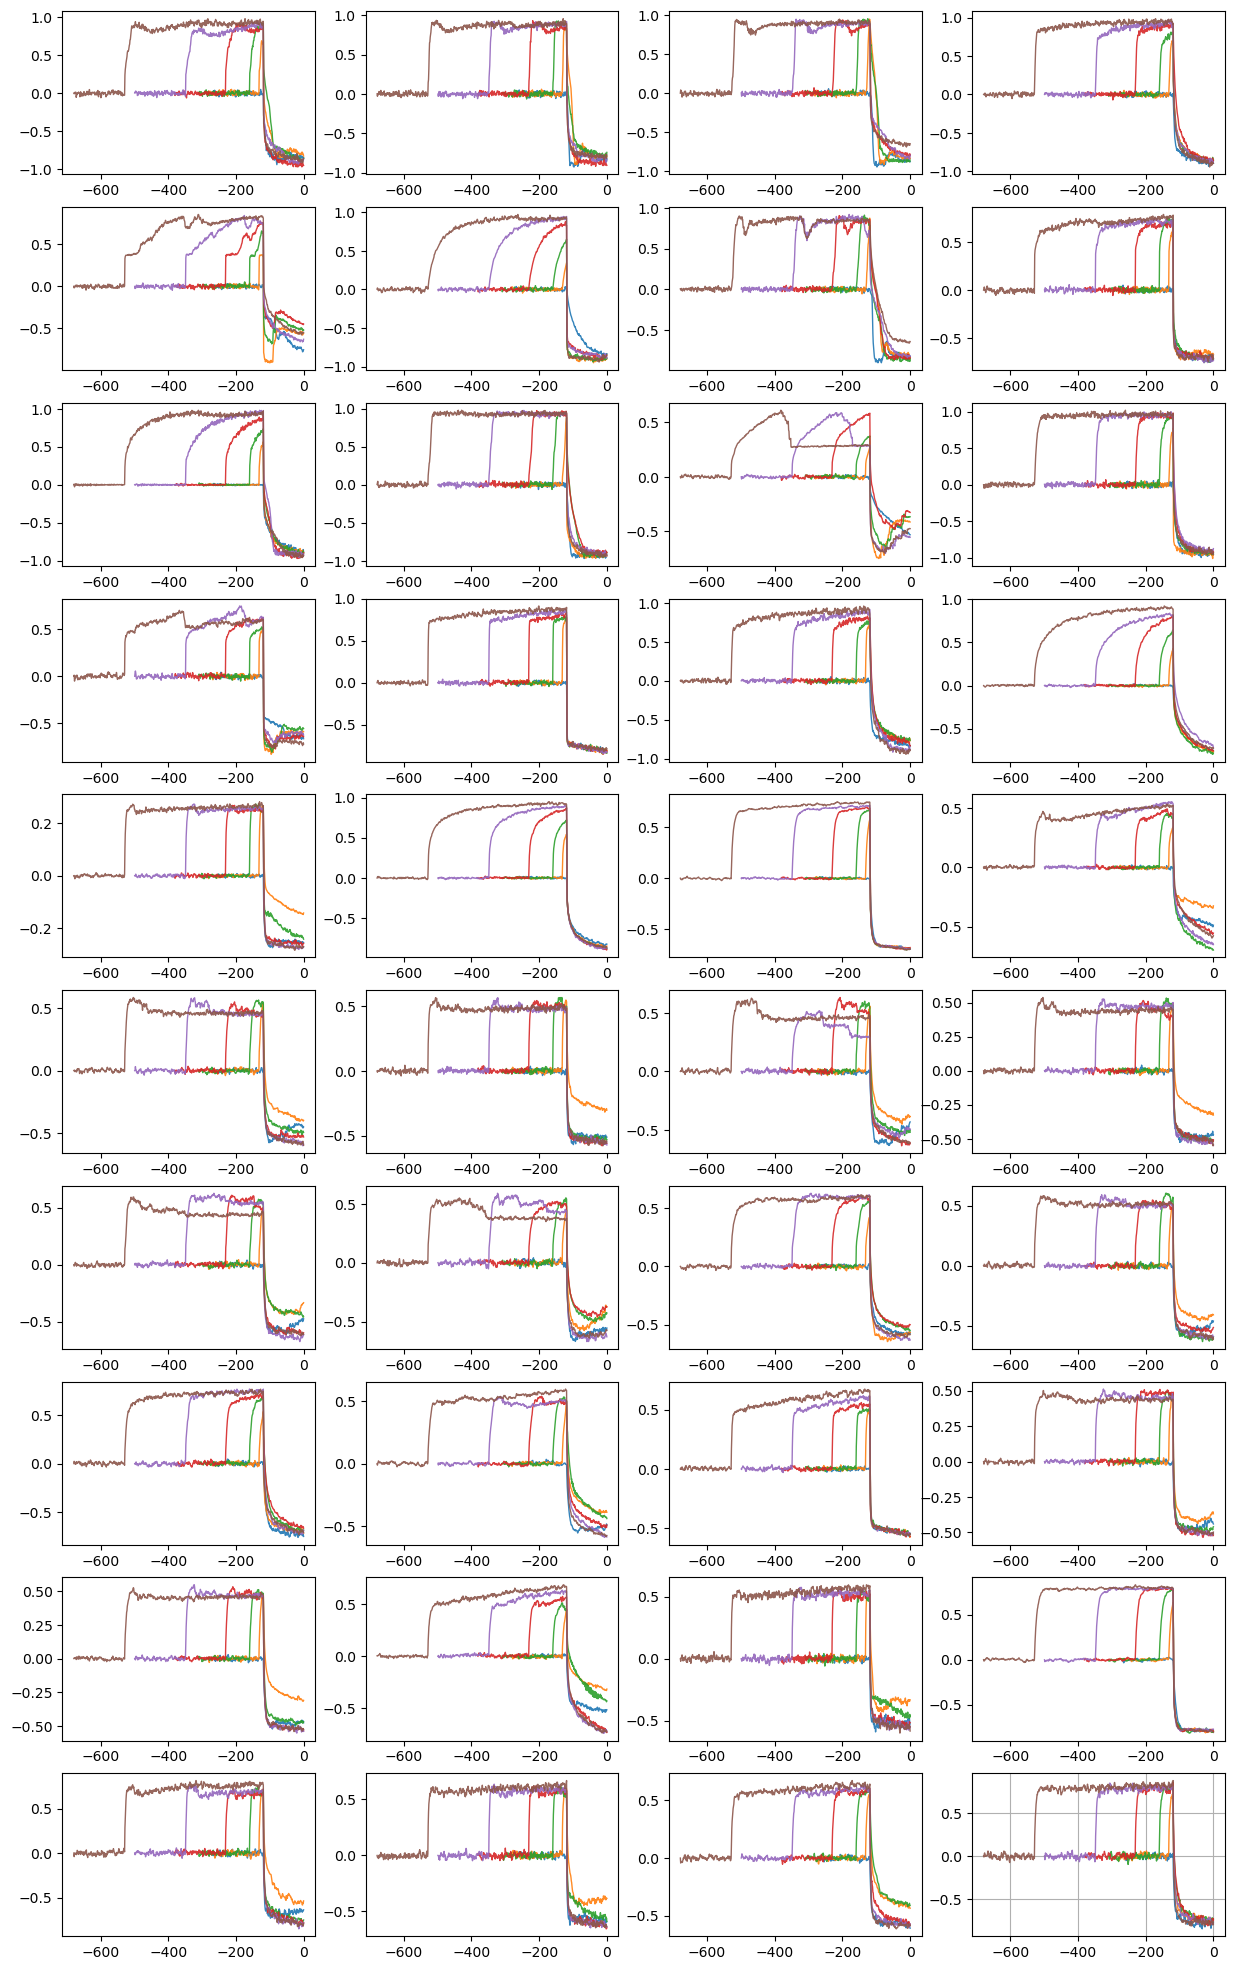

In [19]:
plt.figure(figsize=(15,25))
for ii in range(40):
    for aa,aa_item in antero.items():
        plt.subplot(10,4,ii+1)
        y = antero[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()

In [ ]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.56s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.96s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.45s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.43s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.49s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.17s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.46s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


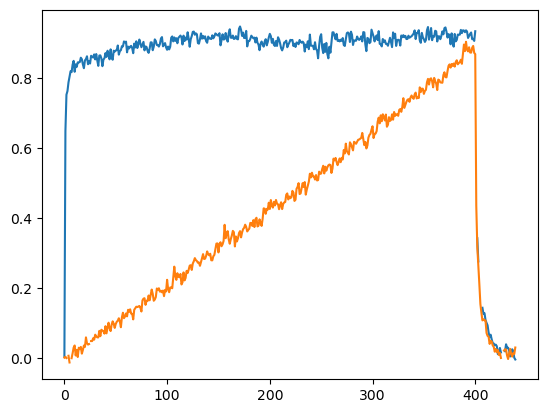

In [ ]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
from siggen_utils import herzfeld_block


def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:47<00:00, 47.82s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.83s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.27s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.95s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:54<00:00, 54.45s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:52<00:00, 52.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:44<00:00, 44.29s/it]


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

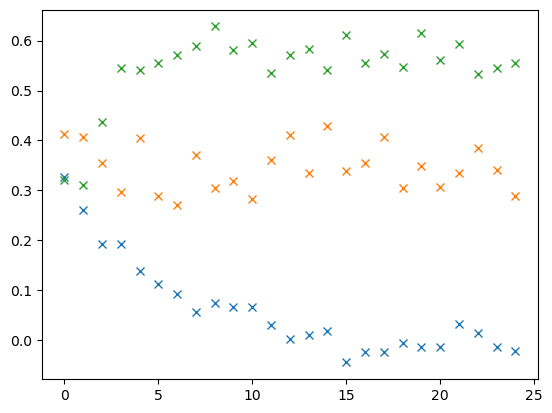

In [ ]:
for iz, z in enumerate(hrz_params['z_list']):
    deltas = []
    mm = lambda x: np.mean(x,axis=0)
    scenario = f'herzfeld,z={z}'
    this_result = her_results[scenario]
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = hrz_playlist[scenario][bb][-1]
        pointer += block_length
        deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

    plt.plot(deltas,'x',label = f'z={z}')

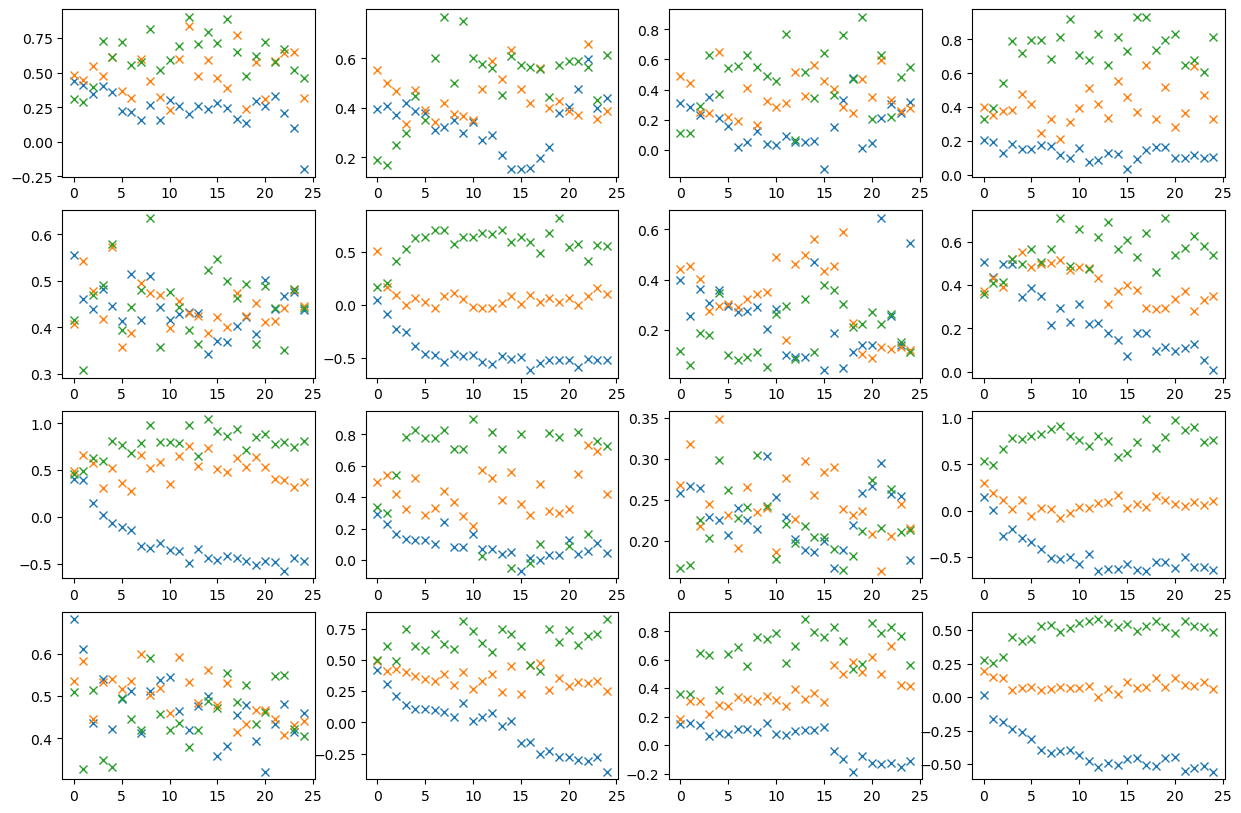

In [ ]:
plt.figure(figsize=(15,10))
for iz, z in enumerate(hrz_params['z_list']):
    for ii in range(16):
        plt.subplot(4,4,ii+1)
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        scenario = f'herzfeld,z={z}'
        this_result = her_results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = hrz_playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append((her_results[scenario])[ii][pointer-1]-(her_results[scenario])[ii][pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')

In [ ]:
plt.figure(figsize=(15,10))
for iz, z in enumerate(hrz_params['z_list']):
    for ii in range(16):
        plt.subplot(4,4,ii+1)
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        scenario = f'herzfeld,z={z}'
        this_result = her_results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = hrz_playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append((her_results[scenario])[ii][pointer-1]-(her_results[scenario])[ii][pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')

NameError: name 'plt' is not defined

In [ ]:
np.shape(her_results[scenario][0][pointer-1])

()

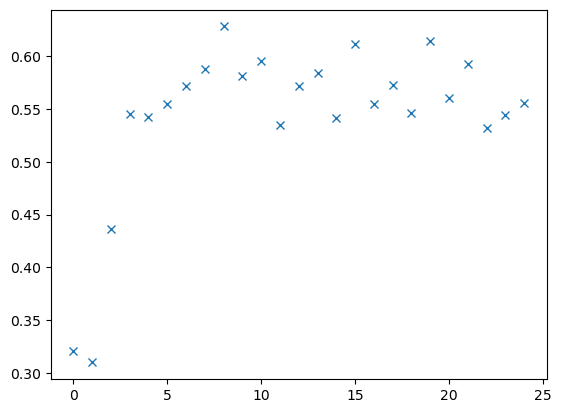

In [ ]:
plt.plot(deltas,'x',label = f'z={z}')

In [ ]:
playlist = {'Ac':[(P0, 200),(Pplus, 200),(Pchannel,200)],
            'ABc':[(P0, 200),(Pplus, 200),(Pminus, 200),(Pchannel,200)]}

results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in playlist.items()}


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:17<00:00, 17.02s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:15<00:00, 15.93s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.68s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:14<00:00, 14.97s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.47s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.86s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.28s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:13<00:00, 13.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.14s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:29<00:00, 29.80s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:24<00:00, 24.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:22<00:00, 22.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:27<00:00, 27.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.24s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.87s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:26<00:00, 26.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:21<00:00, 21.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:26<00:00, 26.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:23<00:00, 23.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:23<00:00, 23.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.17s/it]


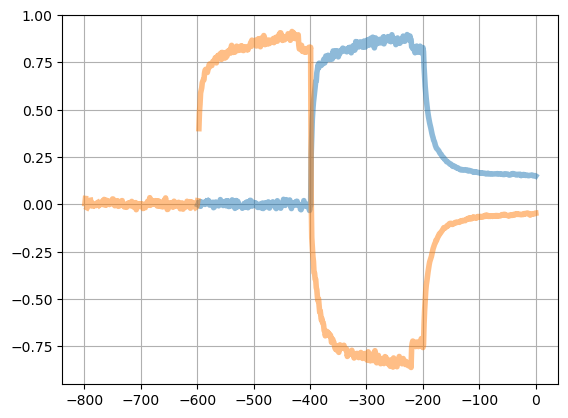

In [ ]:
for aa,aa_item in results.items():
    y = np.mean(results[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y, linewidth=4, alpha=0.5)
plt.grid()

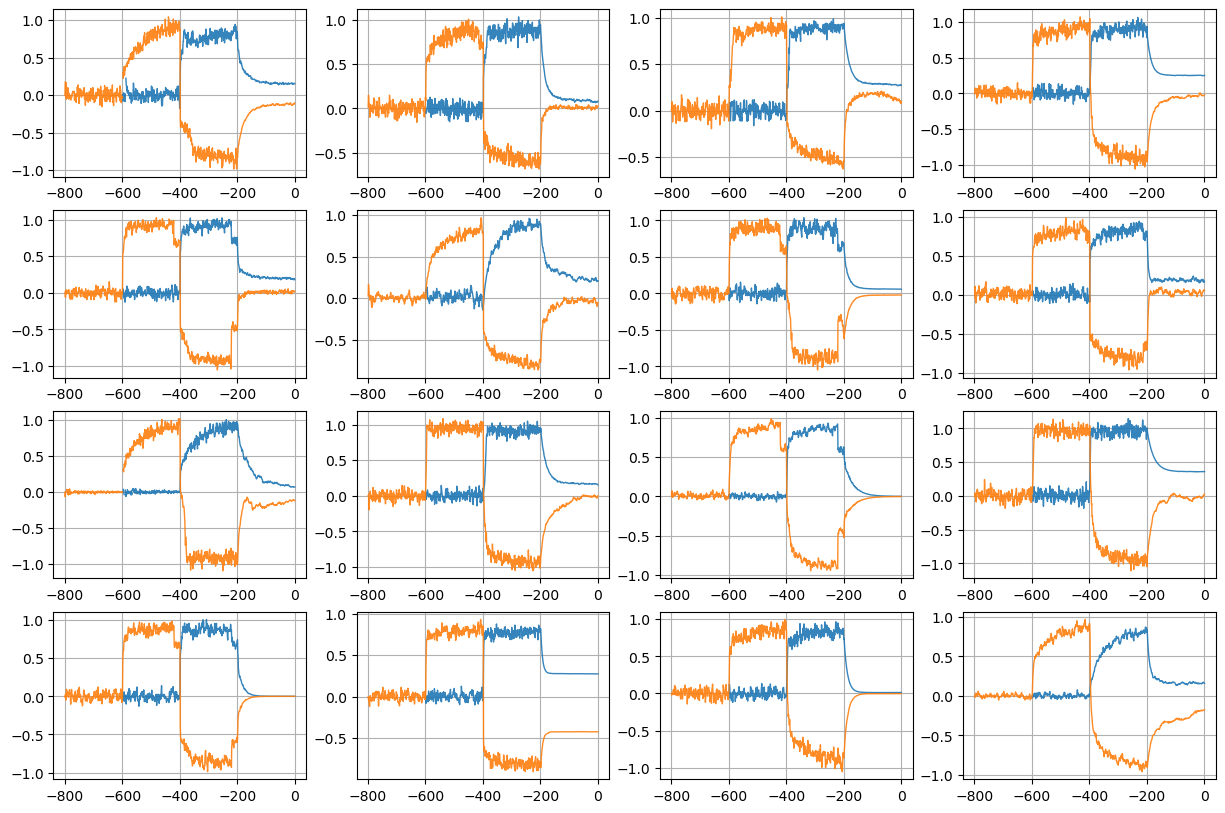

In [ ]:
plt.figure(figsize=(15,10))
for ii in range(16):
    for aa,aa_item in results.items():
        plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
    plt.grid()

In [ ]:
for ii in range(16):
    for aa,aa_item in results.items():
        plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()

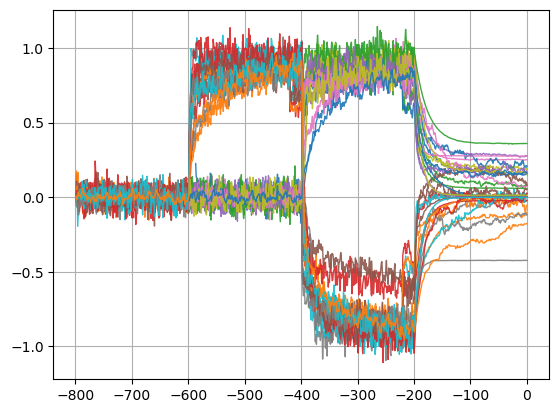

In [ ]:
for ii in range(16):
    for aa,aa_item in results.items():
        # plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()